# Detecting Credit Card Fraud Using Bagging and Boosting Techniques

This project aims to build a fraud detection system using ensemble methods. We work with the Credit Card Fraud Detection dataset which consists of 284,807 transactions with 31 features:
- **Time:** Time elapsed (in seconds) since the first transaction.
- **V1 - V28:** Anonymized principal components representing transaction details.
- **Amount:** Transaction amount.
- **Target:** Transaction label (0 for non-fraud, 1 for fraud).

Fraudulent transactions are very rare (≈ 0.17% of the data), so we apply class imbalance handling (using SMOTE) to improve model performance.



In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

### Loading Dataset


In [2]:

df = pd.read_csv('creditcard.csv')

# Inspect the first few rows of the dataset
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check for missing values in the dataset.
print("Missing values per column:")
print(df.isnull().sum())



Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
# Define the features and target variable
X = df.drop('Class', axis=1) 
y = df['Class']

# Splitting dataset into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:


# adressing imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# new class distribution
print("Class distribution after SMOTE:")
print(y_train_res.value_counts())



Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


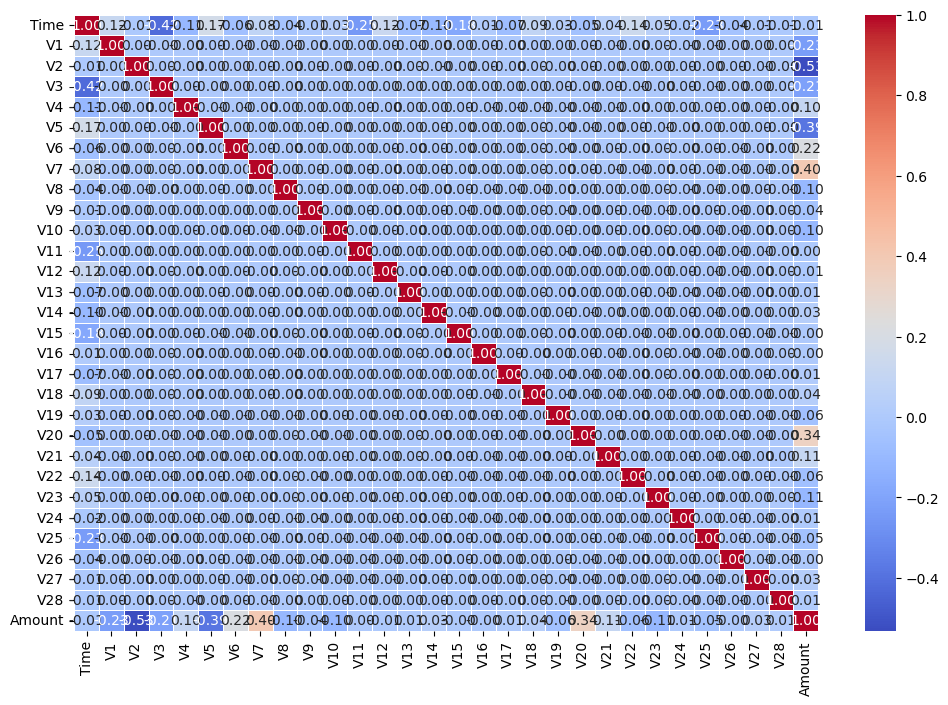

In [6]:

# Feature Scaling
scaler = StandardScaler()

# Fit the scaler on the training data for the 'Amount' and 'Time' columns, then transform both sets
X_train_res[['Amount', 'Time']] = scaler.fit_transform(X_train_res[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])




correlation_matrix = X.corr()
# Plot the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#NO HIGH CORRELATION HENCE WE DECIDED TO KEEP ALL THE FEATURES

### XG Boost

In [45]:
#XGBoost
xg_model = xgb.XGBClassifier(n_estimators=1000, random_state=42, max_depth = 15,  learning_rate=0.05,)
xg_model.fit(X_train_res, y_train_res)
xg_pred = xg_model.predict(X_test)

#This shows that no offerfitting is accouring

print("XGBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, xg_pred))
print("Precision:", precision_score(y_test, xg_pred))
print("Recall:", recall_score(y_test, xg_pred))
print("F1-Score:", f1_score(y_test, xg_pred))
print("\n")

XGBoost Evaluation:
Accuracy: 0.9994908886626171
Precision: 0.8631578947368421
Recall: 0.8367346938775511
F1-Score: 0.8497409326424871




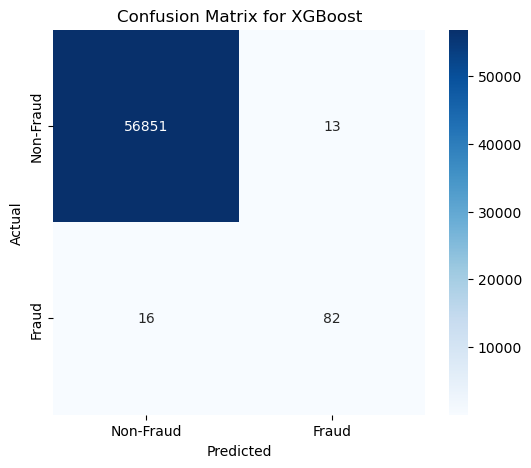

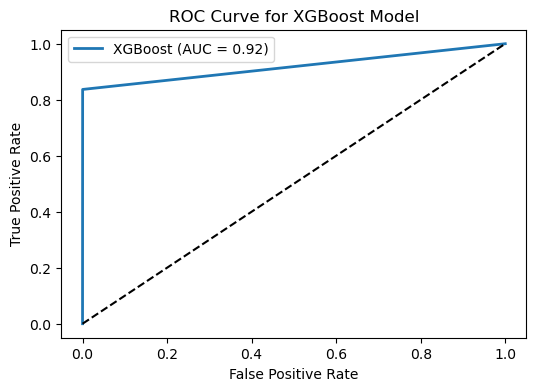

In [46]:
conf_matrix = confusion_matrix(y_test, xg_pred)
# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, xg_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.show()

### Decision tree

In [39]:
dt_model = DecisionTreeClassifier(random_state=42)#Using the dedault values
dt_model.fit(X_train_res, y_train_res)

dt_pred = dt_model.predict(X_test)
print("Decision Tree Evaluation:")
print("Accuracy:", accuracy_score(y_test, dt_pred))
print("Precision:", precision_score(y_test, dt_pred))
print("Recall:", recall_score(y_test, dt_pred))
print("F1-Score:", f1_score(y_test, dt_pred))
print("\n")

Decision Tree Evaluation:
Accuracy: 0.9978582212703205
Precision: 0.4294117647058823
Recall: 0.7448979591836735
F1-Score: 0.5447761194029851




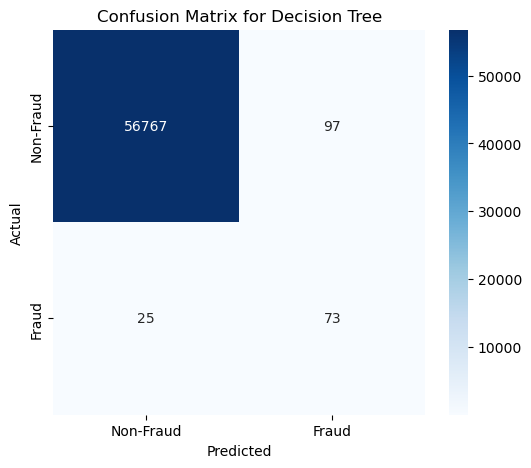

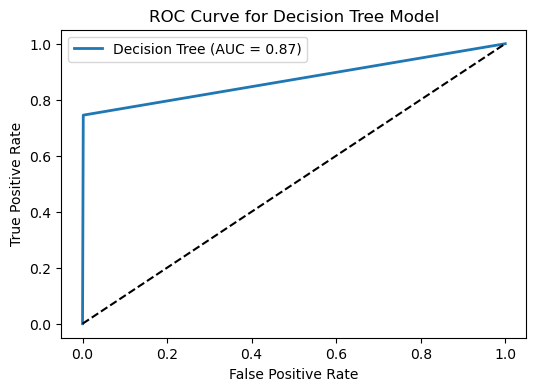

In [40]:
conf_matrix = confusion_matrix(y_test, dt_pred)
# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, dt_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Model')
plt.legend()
plt.show()

### Gradient Boosting

In [30]:
# GradientBoost
gbc_model = GradientBoostingClassifier(n_estimators=100, # n/5 * 22s is the time consumed for the number of estimators
                                learning_rate=0.05,
                                random_state=42,
                                max_depth = 10
                                )
gbc_model.fit(X_train_res, y_train_res)
gbc_pred = gbc_model.predict(X_test)

print("Gradient Boosting Evaluation:")
print("Accuracy:", accuracy_score(y_test, gbc_pred))
print("Precision:", precision_score(y_test, gbc_pred))
print("Recall:", recall_score(y_test, gbc_pred))
print("F1-Score:", f1_score(y_test, gbc_pred))
print("\n")


Gradient Boosting Evaluation:
Accuracy: 0.9989642217618764
Precision: 0.6535433070866141
Recall: 0.8469387755102041
F1-Score: 0.7377777777777778




Gradient Boosting Evaluation:
Accuracy after threshold adjustment: 0.9991397773954567
Precision after threshold adjustment: 0.7207207207207207
Recall after threshold adjustment: 0.8163265306122449
F1-Score after threshold adjustment: 0.7655502392344498




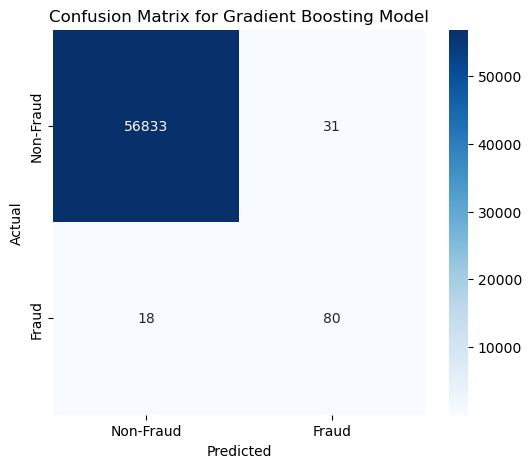

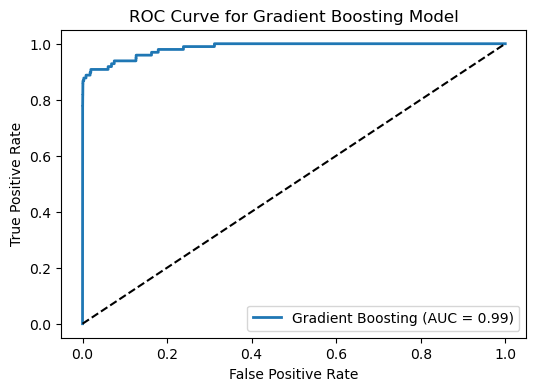

In [41]:
gbc_pred_prob = gbc_model.predict_proba(X_test)[:, 1] 
threshold = 0.70  
gbc_pred_adjusted = (gbc_pred_prob >= threshold).astype(int) 


print("Gradient Boosting Evaluation:")
print("Accuracy after threshold adjustment:", accuracy_score(y_test, gbc_pred_adjusted))
print("Precision after threshold adjustment:", precision_score(y_test, gbc_pred_adjusted))
print("Recall after threshold adjustment:", recall_score(y_test, gbc_pred_adjusted))
print("F1-Score after threshold adjustment:", f1_score(y_test, gbc_pred_adjusted))
print("\n")

conf_matrix = confusion_matrix(y_test, gbc_pred_adjusted)
# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Gradient Boosting Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, gbc_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting Model')
plt.legend()
plt.show()

### Ada Boost


In [8]:
# AdaBoost Model 
ada_model = AdaBoostClassifier(random_state=42, n_estimators=1000)
ada_model.fit(X_train_res, y_train_res)
ada_pred = ada_model.predict(X_test)

print("AdaBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, ada_pred))
print("Precision:", precision_score(y_test, ada_pred))
print("Recall:", recall_score(y_test, ada_pred))
print("F1-Score:", f1_score(y_test, ada_pred))

/home/campus20/nslange2/.conda/envs/cs-ee5841/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Evaluation:
Accuracy: 0.9970506653558513
Precision: 0.35655737704918034
Recall: 0.8877551020408163
F1-Score: 0.5087719298245614


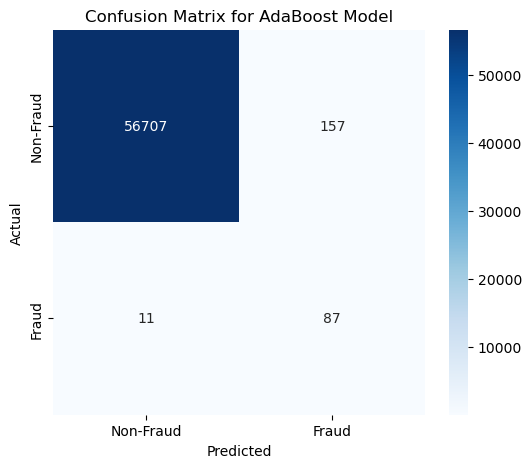

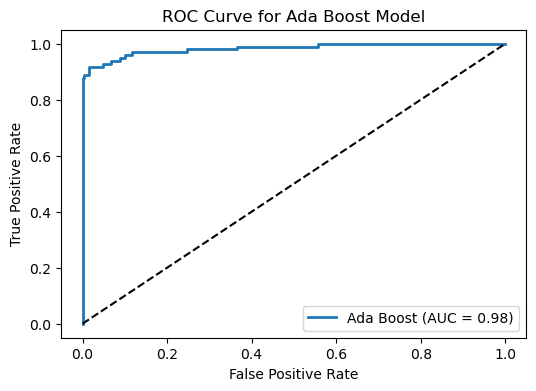

In [47]:
conf_matrix = confusion_matrix(y_test, ada_pred)
# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for AdaBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Get predicted probabilities for the positive class
y_ada_pred_proba = ada_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_ada_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Ada Boost (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ada Boost Model')
plt.legend()
plt.show()

### Random Forrest Model

In [28]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)
rf_pred = rf_model.predict(X_test)
 
print("Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1-Score:", f1_score(y_test, rf_pred))
print("\n")


Random Forest Evaluation:
Accuracy: 0.9995259997893332
Precision: 0.8736842105263158
Recall: 0.8469387755102041
F1-Score: 0.8601036269430051




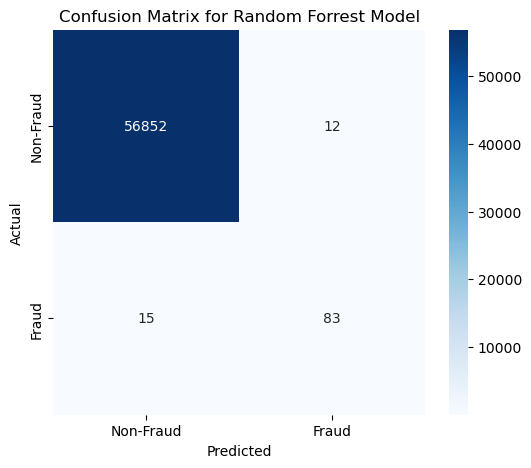

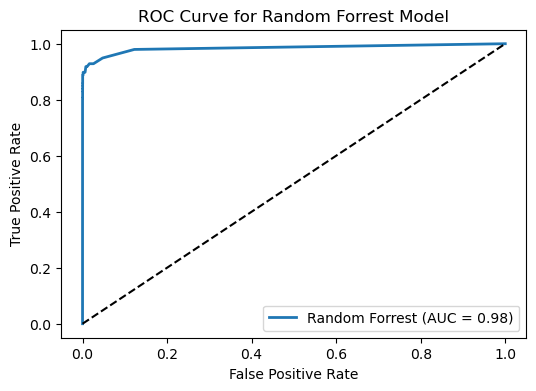

In [34]:
conf_matrix = confusion_matrix(y_test, rf_pred)
# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Random Forrest Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Get predicted probabilities for the positive class
y_rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_rf_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Random Forrest (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forrest Model')
plt.legend()
plt.show()

In [37]:
# AdaBoost Model 
ada_model = AdaBoostClassifier(random_state=42, n_estimators=100)
ada_model.fit(X_train_res, y_train_res)
ada_pred = ada_model.predict(X_test)

print("AdaBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, ada_pred))
print("Precision:", precision_score(y_test, ada_pred))
print("Recall:", recall_score(y_test, ada_pred))
print("F1-Score:", f1_score(y_test, ada_pred))

/home/campus20/nslange2/.conda/envs/cs-ee5841/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Evaluation:
Accuracy: 0.9914153295179242
Precision: 0.15398230088495576
Recall: 0.8877551020408163
F1-Score: 0.26244343891402716
